# Auto Encoder

## Load Dataset

In [1]:
DATASET_NAME = 'dataset-5000'
TEST_DATASET_NAME = 'dataset-test'
BATCH_SIZE = 16
MODEL_PATH = 'model/cnn_residual_stride'

import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms

from torch.utils.data import DataLoader
from util import GeneratedDataset

trainset = GeneratedDataset(DATASET_NAME, transforms.ToTensor())
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

testset = GeneratedDataset(TEST_DATASET_NAME, transforms.ToTensor())
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

if not os.path.exists(MODEL_PATH):
    os.makedirs(MODEL_PATH)

## Define CNN based auto-encoder

- 64 * 64 * 3 image input = 12,288
- Cov3 with 32 channel, 3 * 3 * 3 * 32 = 864 parameters
- ReLU
- MaxPool -> 32 * 32 * 32 hidden state = 32768
- Cov3 with 64 channel, 32 * 3 * 3 * 64 = 18432 parameters
- ReLU
- MaxPool -> 16 * 16 * 64 hidden state = 16384
- Cov3 with 128 channel, 64 * 3 * 3 * 128 = 73728 parameters
- ReLU
- MaxPool -> 8 * 8 * 128 = 8192 hidden state
- Full connected 8192 -> **embedding size**

And the decoder works reversely.

In [2]:
# Define the residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride)

    def forward(self, x):
        residual = self.shortcut(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x += residual
        return x

# Define the autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, embedding_size=32, dropout_rate=0.25):
        super(Autoencoder, self).__init__()
        self.embedding_size = embedding_size

        # Encoder
        self.encoder = nn.Sequential(
            ResidualBlock(3, 32, stride=2),
            nn.Dropout(dropout_rate),
            ResidualBlock(32, 64, stride=2),
            nn.Dropout(dropout_rate),
            ResidualBlock(64, 128, stride=2),
            nn.Dropout(dropout_rate)
        )
        self.fc1 = nn.Linear(8 * 8 * 128, embedding_size)  # Fully connected layer to get 32-length embedding

        # Decoder
        self.fc2 = nn.Linear(embedding_size, 8 * 8 * 128)  # Fully connected layer to reshape back to 8x8x128
        self.decoder = nn.Sequential(
            ResidualBlock(128, 128),
            nn.Upsample(scale_factor=2),
            nn.Dropout(dropout_rate),
            ResidualBlock(128, 64),
            nn.Upsample(scale_factor=2),
            nn.Dropout(dropout_rate),
            ResidualBlock(64, 32),
            nn.Upsample(scale_factor=2),
            nn.Dropout(dropout_rate),
            nn.Conv2d(32, 3, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        encoded = encoded.view(encoded.size(0), -1)  # Flatten the tensor
        encoded = self.fc1(encoded)  # Get the embedding
        decoded = self.fc2(encoded)  # Reshape back to 8x8x128
        decoded = decoded.view(decoded.size(0), 128, 8, 8)
        decoded = self.decoder(decoded)
        return decoded, encoded

In [3]:
from util import train_model_steps, plot_model, count_parameters

def train_model(embedding_size=32, dropout_rate=0.25, learning_rate=1e-4, weight_decay=1e-5, num_epochs=20):
    # Initialize the model
    model = Autoencoder(embedding_size=embedding_size, dropout_rate=dropout_rate)
    print(f'Number of parameters: {count_parameters(model)}')

    model, train_losses, test_losses = train_model_steps(model, trainloader, testloader, learning_rate, weight_decay, num_epochs)
    # Save the model
    torch.save(model.state_dict(), f'{MODEL_PATH}/e{embedding_size}.pth')
    plot_model(model, train_losses, test_losses, testset)
    return model, train_losses, test_losses

## Evaluation

Testing with embedding size of (down from 8192)
- 4
- 8
- 16
- 32
- 64

Number of parameters: 832615
Epoch [1/20], Train Loss: 0.2625, Test Loss: 0.1683
Epoch [2/20], Train Loss: 0.1491, Test Loss: 0.1456
Epoch [3/20], Train Loss: 0.1395, Test Loss: 0.1369
Epoch [4/20], Train Loss: 0.1329, Test Loss: 0.1328
Epoch [5/20], Train Loss: 0.1295, Test Loss: 0.1310
Epoch [6/20], Train Loss: 0.1263, Test Loss: 0.1274
Epoch [7/20], Train Loss: 0.1237, Test Loss: 0.1250
Epoch [8/20], Train Loss: 0.1216, Test Loss: 0.1234
Epoch [9/20], Train Loss: 0.1200, Test Loss: 0.1210
Epoch [10/20], Train Loss: 0.1177, Test Loss: 0.1228
Epoch [11/20], Train Loss: 0.1162, Test Loss: 0.1181
Epoch [12/20], Train Loss: 0.1148, Test Loss: 0.1189
Epoch [13/20], Train Loss: 0.1136, Test Loss: 0.1159
Epoch [14/20], Train Loss: 0.1126, Test Loss: 0.1151
Epoch [15/20], Train Loss: 0.1115, Test Loss: 0.1161
Epoch [16/20], Train Loss: 0.1110, Test Loss: 0.1148
Epoch [17/20], Train Loss: 0.1106, Test Loss: 0.1159
Epoch [18/20], Train Loss: 0.1104, Test Loss: 0.1137
Epoch [19/20], Train Loss:

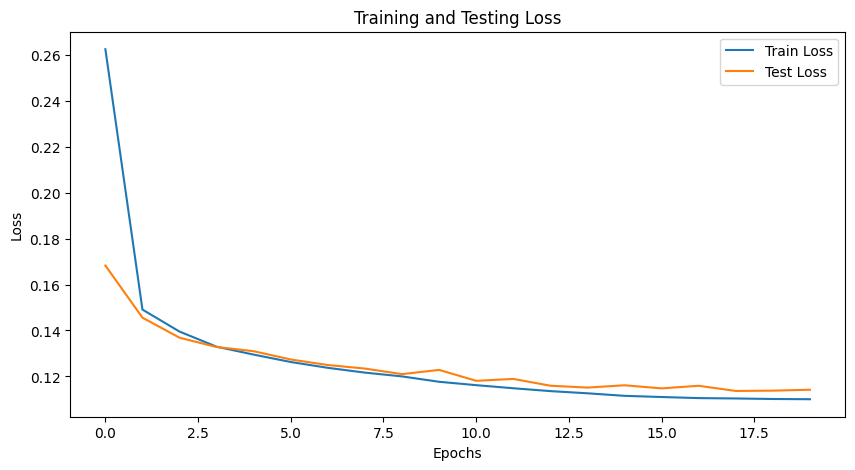

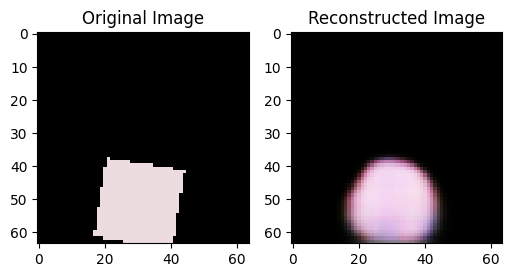

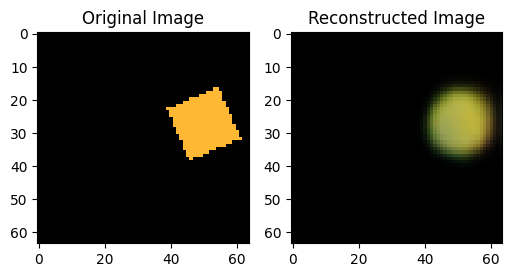

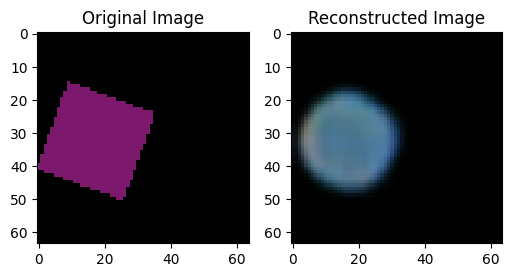

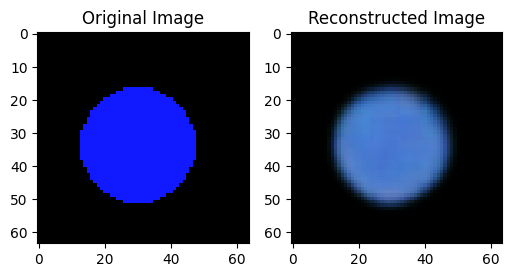

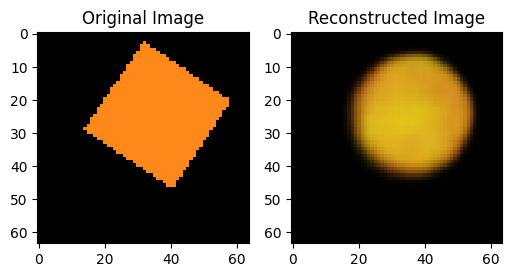

(Autoencoder(
   (encoder): Sequential(
     (0): ResidualBlock(
       (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
       (relu): ReLU()
       (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (shortcut): Conv2d(3, 32, kernel_size=(1, 1), stride=(2, 2))
     )
     (1): Dropout(p=0.1, inplace=False)
     (2): ResidualBlock(
       (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
       (relu): ReLU()
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (shortcut): Conv2d(32, 64, kernel_size=(1, 1), stride=(2, 2))
     )
     (3): Dropout(p=0.1, inplace=False)
     (4): ResidualBlock(
       (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
       (relu): ReLU()
       (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (shortcut): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2))
     )
     (5): Dropout

In [4]:
train_model(embedding_size=4, dropout_rate=0.1)

Number of parameters: 898155
Epoch [1/20], Train Loss: 0.2453, Test Loss: 0.1556
Epoch [2/20], Train Loss: 0.1428, Test Loss: 0.1396
Epoch [3/20], Train Loss: 0.1325, Test Loss: 0.1299
Epoch [4/20], Train Loss: 0.1189, Test Loss: 0.1142
Epoch [5/20], Train Loss: 0.1107, Test Loss: 0.1106
Epoch [6/20], Train Loss: 0.1066, Test Loss: 0.1073
Epoch [7/20], Train Loss: 0.1031, Test Loss: 0.1027
Epoch [8/20], Train Loss: 0.1000, Test Loss: 0.1014
Epoch [9/20], Train Loss: 0.0982, Test Loss: 0.1013
Epoch [10/20], Train Loss: 0.0966, Test Loss: 0.0986
Epoch [11/20], Train Loss: 0.0956, Test Loss: 0.0972
Epoch [12/20], Train Loss: 0.0944, Test Loss: 0.0958
Epoch [13/20], Train Loss: 0.0935, Test Loss: 0.0958
Epoch [14/20], Train Loss: 0.0928, Test Loss: 0.0946
Epoch [15/20], Train Loss: 0.0922, Test Loss: 0.0940
Epoch [16/20], Train Loss: 0.0917, Test Loss: 0.0937
Epoch [17/20], Train Loss: 0.0914, Test Loss: 0.0933
Epoch [18/20], Train Loss: 0.0911, Test Loss: 0.0931
Epoch [19/20], Train Loss:

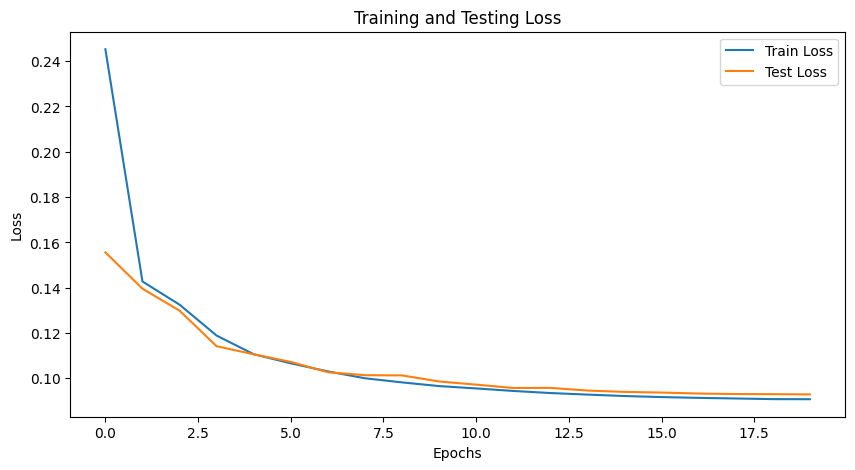

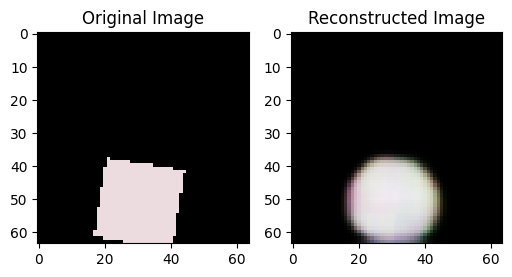

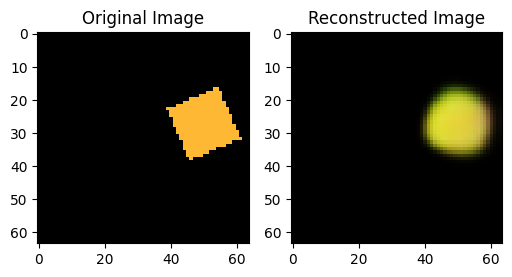

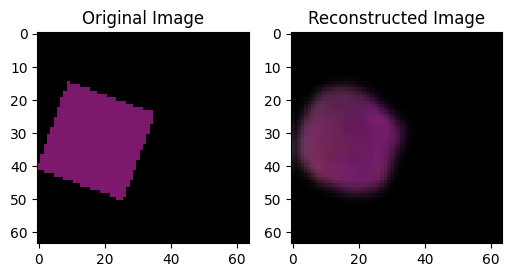

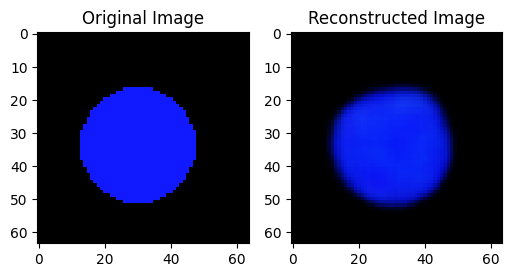

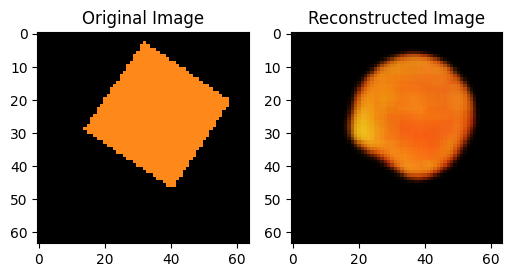

(Autoencoder(
   (encoder): Sequential(
     (0): ResidualBlock(
       (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
       (relu): ReLU()
       (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (shortcut): Conv2d(3, 32, kernel_size=(1, 1), stride=(2, 2))
     )
     (1): Dropout(p=0.1, inplace=False)
     (2): ResidualBlock(
       (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
       (relu): ReLU()
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (shortcut): Conv2d(32, 64, kernel_size=(1, 1), stride=(2, 2))
     )
     (3): Dropout(p=0.1, inplace=False)
     (4): ResidualBlock(
       (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
       (relu): ReLU()
       (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (shortcut): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2))
     )
     (5): Dropout

In [5]:
train_model(embedding_size=8, dropout_rate=0.1)

Number of parameters: 1029235
Epoch [1/20], Train Loss: 0.2280, Test Loss: 0.1485
Epoch [2/20], Train Loss: 0.1391, Test Loss: 0.1403
Epoch [3/20], Train Loss: 0.1286, Test Loss: 0.1217
Epoch [4/20], Train Loss: 0.1141, Test Loss: 0.1090
Epoch [5/20], Train Loss: 0.1052, Test Loss: 0.1040
Epoch [6/20], Train Loss: 0.0983, Test Loss: 0.0963
Epoch [7/20], Train Loss: 0.0932, Test Loss: 0.0920
Epoch [8/20], Train Loss: 0.0901, Test Loss: 0.0899
Epoch [9/20], Train Loss: 0.0882, Test Loss: 0.0887
Epoch [10/20], Train Loss: 0.0868, Test Loss: 0.0877
Epoch [11/20], Train Loss: 0.0856, Test Loss: 0.0864
Epoch [12/20], Train Loss: 0.0846, Test Loss: 0.0858
Epoch [13/20], Train Loss: 0.0838, Test Loss: 0.0852
Epoch [14/20], Train Loss: 0.0831, Test Loss: 0.0847
Epoch [15/20], Train Loss: 0.0824, Test Loss: 0.0838
Epoch [16/20], Train Loss: 0.0820, Test Loss: 0.0834
Epoch [17/20], Train Loss: 0.0817, Test Loss: 0.0832
Epoch [18/20], Train Loss: 0.0814, Test Loss: 0.0828
Epoch [19/20], Train Loss

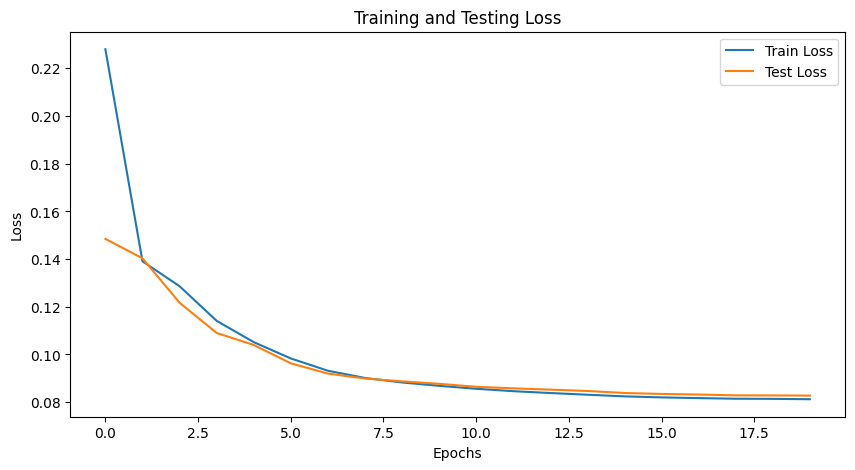

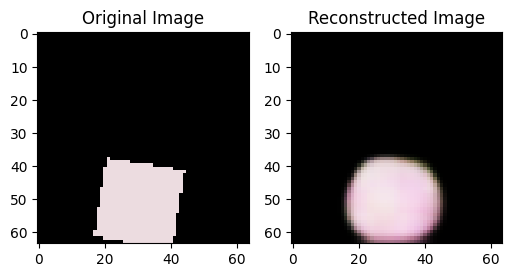

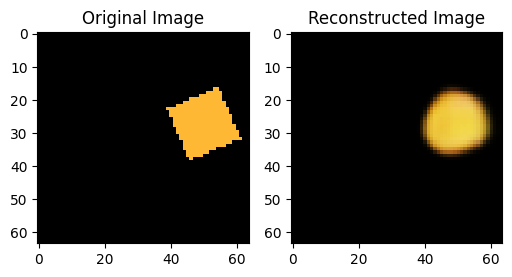

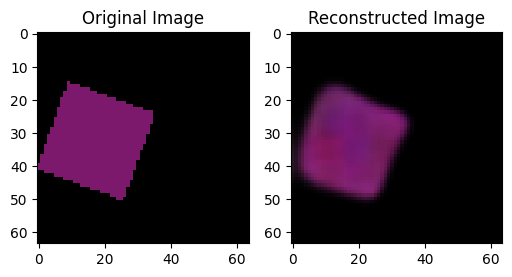

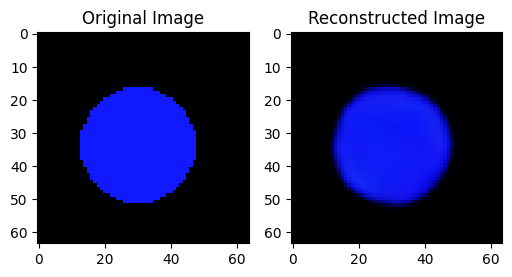

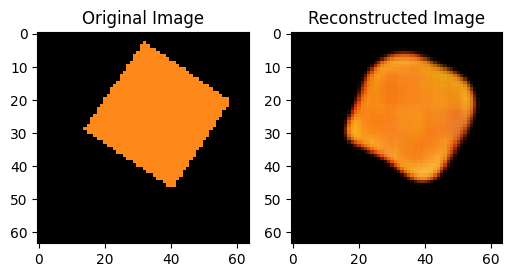

(Autoencoder(
   (encoder): Sequential(
     (0): ResidualBlock(
       (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
       (relu): ReLU()
       (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (shortcut): Conv2d(3, 32, kernel_size=(1, 1), stride=(2, 2))
     )
     (1): Dropout(p=0.1, inplace=False)
     (2): ResidualBlock(
       (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
       (relu): ReLU()
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (shortcut): Conv2d(32, 64, kernel_size=(1, 1), stride=(2, 2))
     )
     (3): Dropout(p=0.1, inplace=False)
     (4): ResidualBlock(
       (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
       (relu): ReLU()
       (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (shortcut): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2))
     )
     (5): Dropout

In [6]:
train_model(embedding_size=16, dropout_rate=0.1)

Number of parameters: 1291395
Epoch [1/20], Train Loss: 0.2330, Test Loss: 0.1495
Epoch [2/20], Train Loss: 0.1395, Test Loss: 0.1357
Epoch [3/20], Train Loss: 0.1231, Test Loss: 0.1130
Epoch [4/20], Train Loss: 0.1079, Test Loss: 0.1072
Epoch [5/20], Train Loss: 0.1000, Test Loss: 0.0992
Epoch [6/20], Train Loss: 0.0928, Test Loss: 0.0926
Epoch [7/20], Train Loss: 0.0888, Test Loss: 0.0881
Epoch [8/20], Train Loss: 0.0861, Test Loss: 0.0862
Epoch [9/20], Train Loss: 0.0841, Test Loss: 0.0844
Epoch [10/20], Train Loss: 0.0828, Test Loss: 0.0837
Epoch [11/20], Train Loss: 0.0814, Test Loss: 0.0821
Epoch [12/20], Train Loss: 0.0805, Test Loss: 0.0814
Epoch [13/20], Train Loss: 0.0796, Test Loss: 0.0806
Epoch [14/20], Train Loss: 0.0789, Test Loss: 0.0801
Epoch [15/20], Train Loss: 0.0784, Test Loss: 0.0795
Epoch [16/20], Train Loss: 0.0780, Test Loss: 0.0794
Epoch [17/20], Train Loss: 0.0777, Test Loss: 0.0791
Epoch [18/20], Train Loss: 0.0775, Test Loss: 0.0787
Epoch [19/20], Train Loss

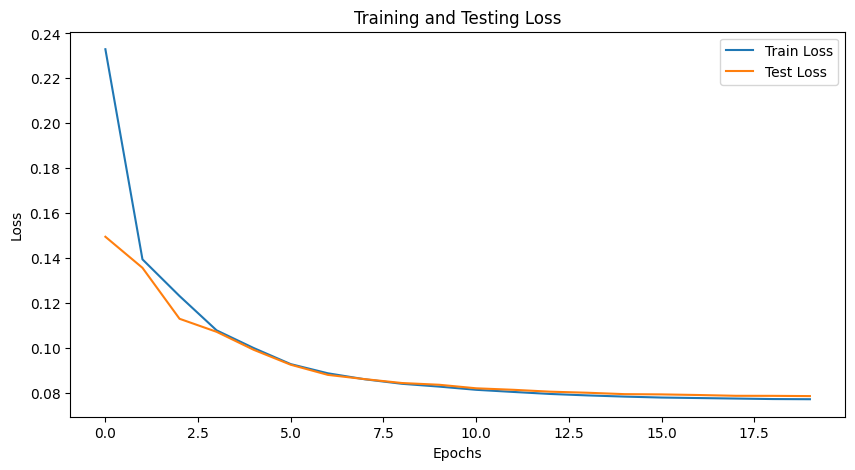

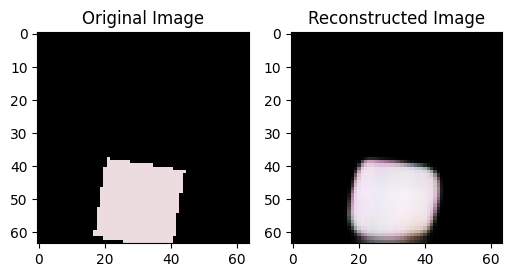

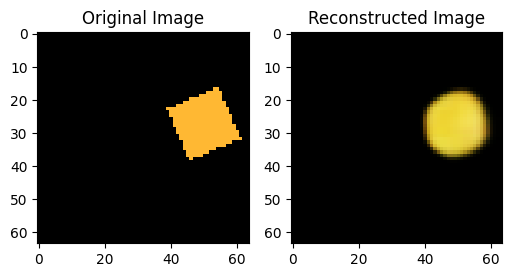

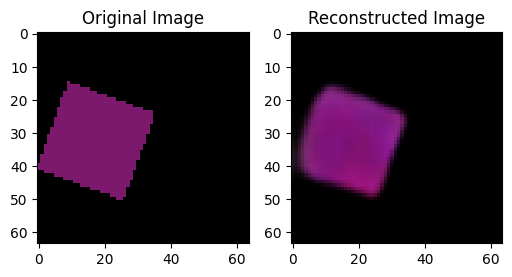

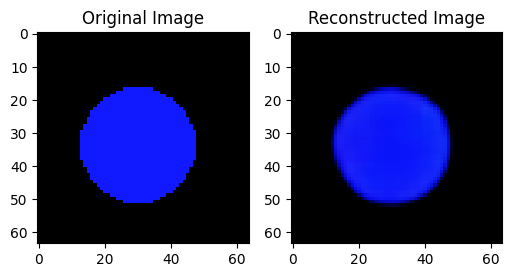

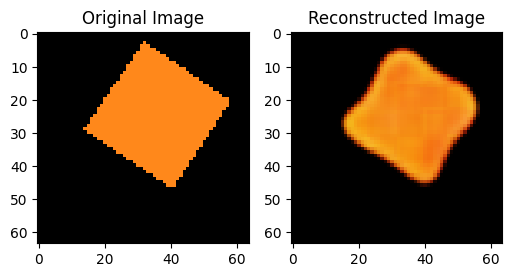

(Autoencoder(
   (encoder): Sequential(
     (0): ResidualBlock(
       (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
       (relu): ReLU()
       (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (shortcut): Conv2d(3, 32, kernel_size=(1, 1), stride=(2, 2))
     )
     (1): Dropout(p=0.1, inplace=False)
     (2): ResidualBlock(
       (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
       (relu): ReLU()
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (shortcut): Conv2d(32, 64, kernel_size=(1, 1), stride=(2, 2))
     )
     (3): Dropout(p=0.1, inplace=False)
     (4): ResidualBlock(
       (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
       (relu): ReLU()
       (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (shortcut): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2))
     )
     (5): Dropout

In [7]:
train_model(embedding_size=32, dropout_rate=0.1)

Number of parameters: 1815715
Epoch [1/20], Train Loss: 0.2302, Test Loss: 0.1496
Epoch [2/20], Train Loss: 0.1375, Test Loss: 0.1335
Epoch [3/20], Train Loss: 0.1186, Test Loss: 0.1106
Epoch [4/20], Train Loss: 0.1044, Test Loss: 0.1038
Epoch [5/20], Train Loss: 0.0970, Test Loss: 0.0948
Epoch [6/20], Train Loss: 0.0892, Test Loss: 0.0877
Epoch [7/20], Train Loss: 0.0848, Test Loss: 0.0854
Epoch [8/20], Train Loss: 0.0825, Test Loss: 0.0829
Epoch [9/20], Train Loss: 0.0809, Test Loss: 0.0819
Epoch [10/20], Train Loss: 0.0796, Test Loss: 0.0803
Epoch [11/20], Train Loss: 0.0788, Test Loss: 0.0793
Epoch [12/20], Train Loss: 0.0777, Test Loss: 0.0790
Epoch [13/20], Train Loss: 0.0771, Test Loss: 0.0779
Epoch [14/20], Train Loss: 0.0765, Test Loss: 0.0776
Epoch [15/20], Train Loss: 0.0761, Test Loss: 0.0772
Epoch [16/20], Train Loss: 0.0758, Test Loss: 0.0769
Epoch [17/20], Train Loss: 0.0755, Test Loss: 0.0767
Epoch [18/20], Train Loss: 0.0753, Test Loss: 0.0765
Epoch [19/20], Train Loss

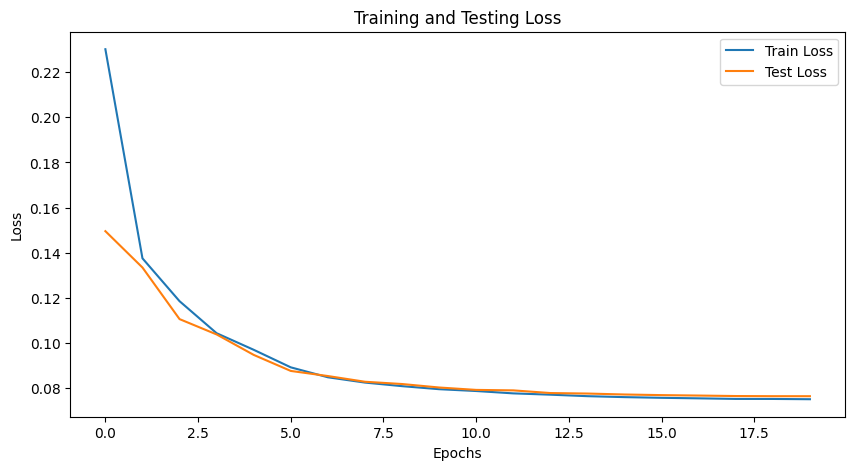

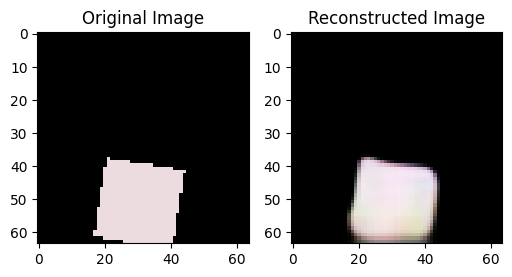

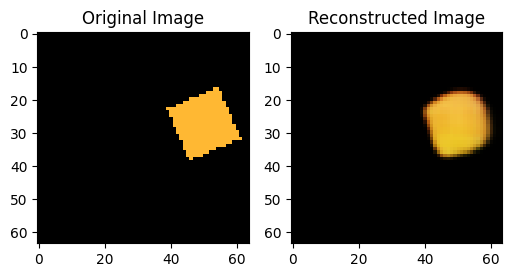

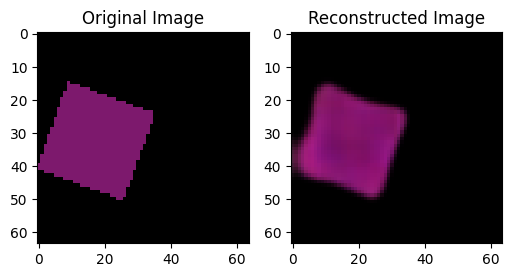

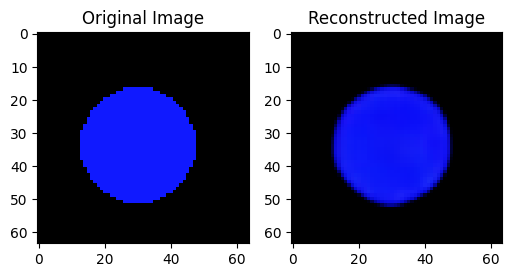

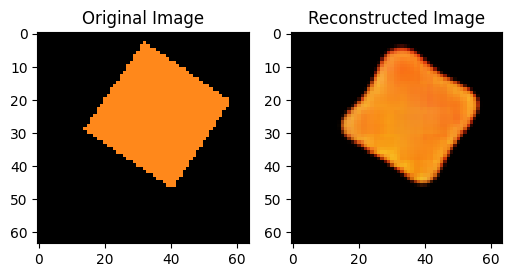

(Autoencoder(
   (encoder): Sequential(
     (0): ResidualBlock(
       (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
       (relu): ReLU()
       (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (shortcut): Conv2d(3, 32, kernel_size=(1, 1), stride=(2, 2))
     )
     (1): Dropout(p=0.1, inplace=False)
     (2): ResidualBlock(
       (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
       (relu): ReLU()
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (shortcut): Conv2d(32, 64, kernel_size=(1, 1), stride=(2, 2))
     )
     (3): Dropout(p=0.1, inplace=False)
     (4): ResidualBlock(
       (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
       (relu): ReLU()
       (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (shortcut): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2))
     )
     (5): Dropout

In [8]:
train_model(embedding_size=64, dropout_rate=0.1)